In [29]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## HyperLogLog

In this task we use the HLL data structure to produce an estimate of the number of distinct strings in the file `hash.txt`.

The command `cat hash.txt | uniq | wc -l` has been used to produce the exact count which is *139000000* distinct strings.

The underlying hash function used by HLL has been implemented according to the **multiply-shift** scheme defined on [Wikipedia](https://en.wikipedia.org/wiki/Universal_hashing). 

We use *32 bits* for the hash, i.e. $$h:\big\{U \rightarrow [m]\big\}$$ where $m=2048$.

We then use *6 bits* for the buckets, i.e. *64 buckets*, so according to [Flajolet et. al](http://algo.inria.fr/flajolet/Publications/FlFuGaMe07.pdf) we can expect $1.04/\sqrt(m)$ relative accuracy.

Recall the formula of relative accuracy is given by:

$$RE_{accuracy} = \frac{\mbox{absolute error}}{\mbox{"true" value}} \cdot 100\%$$

Which in this setting should expect a **2.30% relative accuracy**

In [40]:
from my_hyperloglog import *

estimate = estimate_distinct("full_hash.txt")
re_acc = relative_accuracy(estimate)

print("Distinct elements: ", estimate)
print("Relative accuracy: {:.2%}".format(re_acc))

Distinct elements:  141943507
Relative accuracy: 2.12%


## Cluster analysis of Amazon Reviews

The goal in this task is to cluster the reviews from [fine foods from Amazon](https://www.kaggle.com/snap/amazon-fine-food-reviews) using the **KMeans algorithm** and then do some visualization on the result. We'll using the tfidf representation of the preprocessed reviews and then reduce the dimension with a SVD to be able to work more efficiently on a few dimensions.

Here's the dataset we're working on:

In [34]:
from utils import *

reviews_df = load_data()
reviews_df.head()

,ProductId,UserId,Score,Text
0,B001E4KFG0,A3SGXH7AUHU8GW,5,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,1,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,4,This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,2,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,5,Great taffy at a great price. There was a wid...


The reviews have been preprocessed keeping both the stemmed and non-stemmed version. A standard removal of punctuation, digits and html tags has been applied.

In [39]:
reviews_df = load_data(processed=True)
not_na_mask = reviews_df['ProcessedText'].notna()
reviews_df = reviews_df[not_na_mask]
reviews_df.head()

,ProductId,UserId,Score,Text,ProcessedText,Text_not_stemmed
0,B001E4KFG0,A3SGXH7AUHU8GW,5,I have bought several of the Vitality canned d...,vitality food product quality product stew mea...,bought several vitality canned dog food produc...
1,B00813GRG4,A1D87F6ZCVE5NK,1,Product arrived labeled as Jumbo Salted Peanut...,product jumbo salted peanuts peanut error vend...,product arrived labeled jumbo salted peanuts p...
2,B000LQOCH0,ABXLMWJIXXAIN,4,This is a confection that has been around a fe...,confection century pillowy citrus gelatin nut ...,confection around centuries light pillowy citr...
3,B000UA0QIQ,A395BORC6FGVXV,2,If you are looking for the secret ingredient i...,ingredient robitussin addition root beer extra...,looking secret ingredient robitussin believe f...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,5,Great taffy at a great price. There was a wid...,great taffy price assortment yummy taffy deliv...,great taffy great price wide assortment yummy ...


### Exploratory analysis

Since the clustering algorithm will essensially form cluster among similar reviews it makes sense to analyze the words in the corpus to see if there's something we can aim to filter. Ideally we would like to use words that are frequently occurring in reviews but not so much that it would make every review "similar" in the tfidf space.

In [36]:
counter = get_counter(processed_reviews_df)

In [53]:
print("Total words: ", len(counter))

Total words:  89538


As expected looking at some of the most common words there are lots of words that we could filter out when creating the tfidf vectors.

In [37]:
print(counter.most_common(20))

[('product', 183165), ('flavor', 182208), ('coffee', 172369), ('food', 148638), ('tea', 144411), ('taste', 139824), ('dog', 102241), ('time', 100303), ('amazon', 85771), ('bag', 82513), ('cup', 81558), ('price', 80771), ('day', 68210), ('box', 63977), ('store', 63562), ('treat', 62708), ('water', 62524), ('cat', 60525), ('year', 59921), ('chocolate', 59734)]


One option is to filter out everything that is not a noun as well as adding some keyword that was just observed through the analysis. Notice that this step is very task specific, if we were going to make a sentiment analysis to predict the quality of a product we'd definitely keep the adjectives.

In [40]:
to_filter = words_to_filter(reviews_df['Text_not_stemmed'])
len(to_filter)

49105

In [84]:
len(set(" ".join(reviews_df.ProcessedText).split()))

89538

Experimenting with this approach didn't lead to the expected results as lots of variance was lost and the difference in components from the tfidf filtering and the SVD was negligible.

What ultimately worked better in practice was filtering out words that were appearing only on a small percentage of documents, since we aim to group by a relatively small number of clusters it makes sense to drop words that are unlikely to be shared by the reviews, which would just increase the intercluster variance.

To transform the reviews into high dimensional vectors in order to run the kmeans algorithm we first compute the tfidf representation and then run SVD to further reduce the number of dimensions.

The `min_df` and `max_df` parameters have been used to filter out words that are too frequent or too rare. We will keep words appearing in at least 1% of the reviews. The reason we don't want words that are too rare is that later on when we reduce the dimension we want as few words as possible to explain the differences in clusters, and having coordinate (words) where most vectors differ but a few would result in a higher number of dimensions to keep to achieve the same retained variance.

In [121]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', min_df=0.07)

reviews_tfidf = tfidf.fit_transform(reviews_df['ProcessedText'])
reviews_tfidf.shape

(568312, 19)

We can further reduce the number of dimension using the SVD, in the graph below we see how the number of components affects the retained variance. We will use a number that allows to retain at least 60% variance.

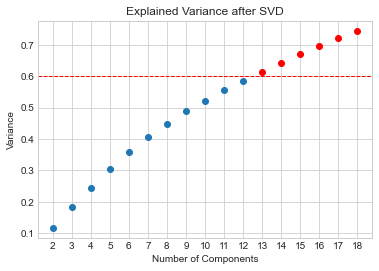

In [130]:
plot_variance(reviews_tfidf)

From the graph above is clear that picking $k=15$ is a wise choice.

In [129]:
svd = TruncatedSVD(n_components=13)
points = svd.fit_transform(reviews_tfidf)
print("Retained variance: {:.2%}".format(svd.explained_variance_.sum()))

Retained variance: 61.48%


To run KMeans we need to decide the number of clusters, one way to do it is using the **elbow method**, we look for a clear bend in the graph of **sum of squares error** as the number of clusters increases.

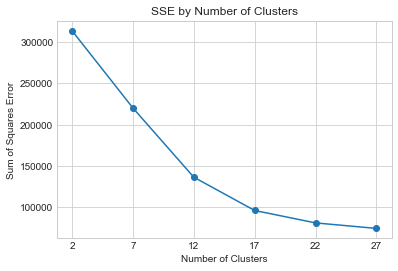

In [132]:
simulation_data = kmeans_simulation(points,
                                    max_centroids=30,
                                    skip=5)
plot_sse(simulation_data)

Before we move on with the exploratory analysis let's compare this implementation with **sklearn KMeans**.

In [ ]:
from sklearn.cluster import KMeans

sklearn_simulation_data = kmeans_simulation(points, kmeans_class=KMeans)
plot_sse_comparison(sklearn_simulation_data, simulation_data)

As we can see the sse error is almost the same, we can also compare the differences in execution time.

In [ ]:
plot_performance(sklearn_simulation_data, simulation_data)

Let's now focus on the result of clustering with $k=14$ from above.

In [36]:
custom_kmeans = CustomKMeans(n_clusters=14)
clusters = custom_kmeans.fit_predict(points)

Here's the number of different products per cluster.

In [43]:
processed_reviews_df['Cluster'] = clusters
cols = ['ProductId', 'Cluster']
processed_reviews_df[cols].groupby(['Cluster']).agg({"ProductId":"nunique"})

,ProductId
Cluster,
0,17800
1,17126
2,15180
3,18870
4,14972
5,16767
6,10073
7,20059
8,18521
